In [1]:
from qiskit.circuit import *
import numpy as np
from qiskit_aer import StatevectorSimulator
from qiskit.result import marginal_counts
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.visualization.state_visualization import _bloch_multivector_data
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.add_control import add_control
from qiskit import transpile

import functools


In [2]:
def inverse_qft(n: int, qc: QuantumCircuit):
    iqft = QuantumCircuit(qc.qubits[:n])
    # swap
    for i in range(n-1,-1,-1):
        iqft.h(i)
        for j in range(i):
            iqft.cp(np.pi/2**(i-j),j,i)

    for i in range(n//2):
        iqft.swap(i,n-1-i)
    iqft.barrier()
    iqft.name='iqft'
    qc.append(iqft.inverse(True),iqft.qubits)

In [3]:
from typing import Callable, Sequence
def phase_estimation(n: int, qc: QuantumCircuit, u_control: ControlledGate, u_target_circuit: QuantumCircuit):
    num_qc_bits = qc.num_qubits
    qc_bits = qc.qubits

    num_u_target_bits = u_target_circuit.num_qubits
    u_target_bits = u_target_circuit.qubits

    qc.add_bits(u_target_bits)
    qc.compose(u_target_circuit,u_target_bits,inplace=True)

    phase_qc = QuantumCircuit(qc.qubits)
    
    for i in range(num_qc_bits):
        phase_qc.h(i)
        for _ in range(2**i):
            phase_qc.append(u_control,[qc_bits[i]]+u_target_bits)

    qc.compose(phase_qc,inplace=True)
    inverse_qft(num_qc_bits,qc)



In [4]:
from scipy.stats import unitary_group
# T gate: rotate by pi/4
umatT = np.array([[1,0],[0,np.exp(np.pi*1j/4)]])
# random unitary gate
umatT = unitary_group.rvs(2)
eig_vals,eig_vecs=np.linalg.eig(umatT)
eig_vec = eig_vecs[1]
eig_val = eig_vals[1]

print(f"eigen vectors: {eig_vecs}")
print(f"eigen values: {eig_vals}")

print(f"eig_vec: {eig_vec}")

eigen vectors: [[ 0.85860929+0.j          0.21863759-0.46366765j]
 [-0.21863759-0.46366765j  0.85860929+0.j        ]]
eigen values: [ 0.98857094+0.1507564j  -0.66191021+0.74958314j]
eig_vec: [-0.21863759-0.46366765j  0.85860929+0.j        ]


In [5]:
n: int = 5
import qiskit.quantum_info as qi
# init the target circuit for controlled gate
qc2 = QuantumCircuit(n)
control_circuit=QuantumCircuit(1)
# pick the second eigenvector for higher probability of 1
control_circuit.initialize(eig_vec,control_circuit.qubits[0])
gateT=UnitaryGate(umatT).control(ctrl_state=1)
phase_estimation(n,qc2,gateT,control_circuit)

qc2.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=6, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'q'), 0), Qubit(QuantumRegister(5, 'q'), 1), Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3), Qubit(QuantumRegister(5, 'q'), 4), Qubit(QuantumRegister(1, 'q'), 0)), clbits=())

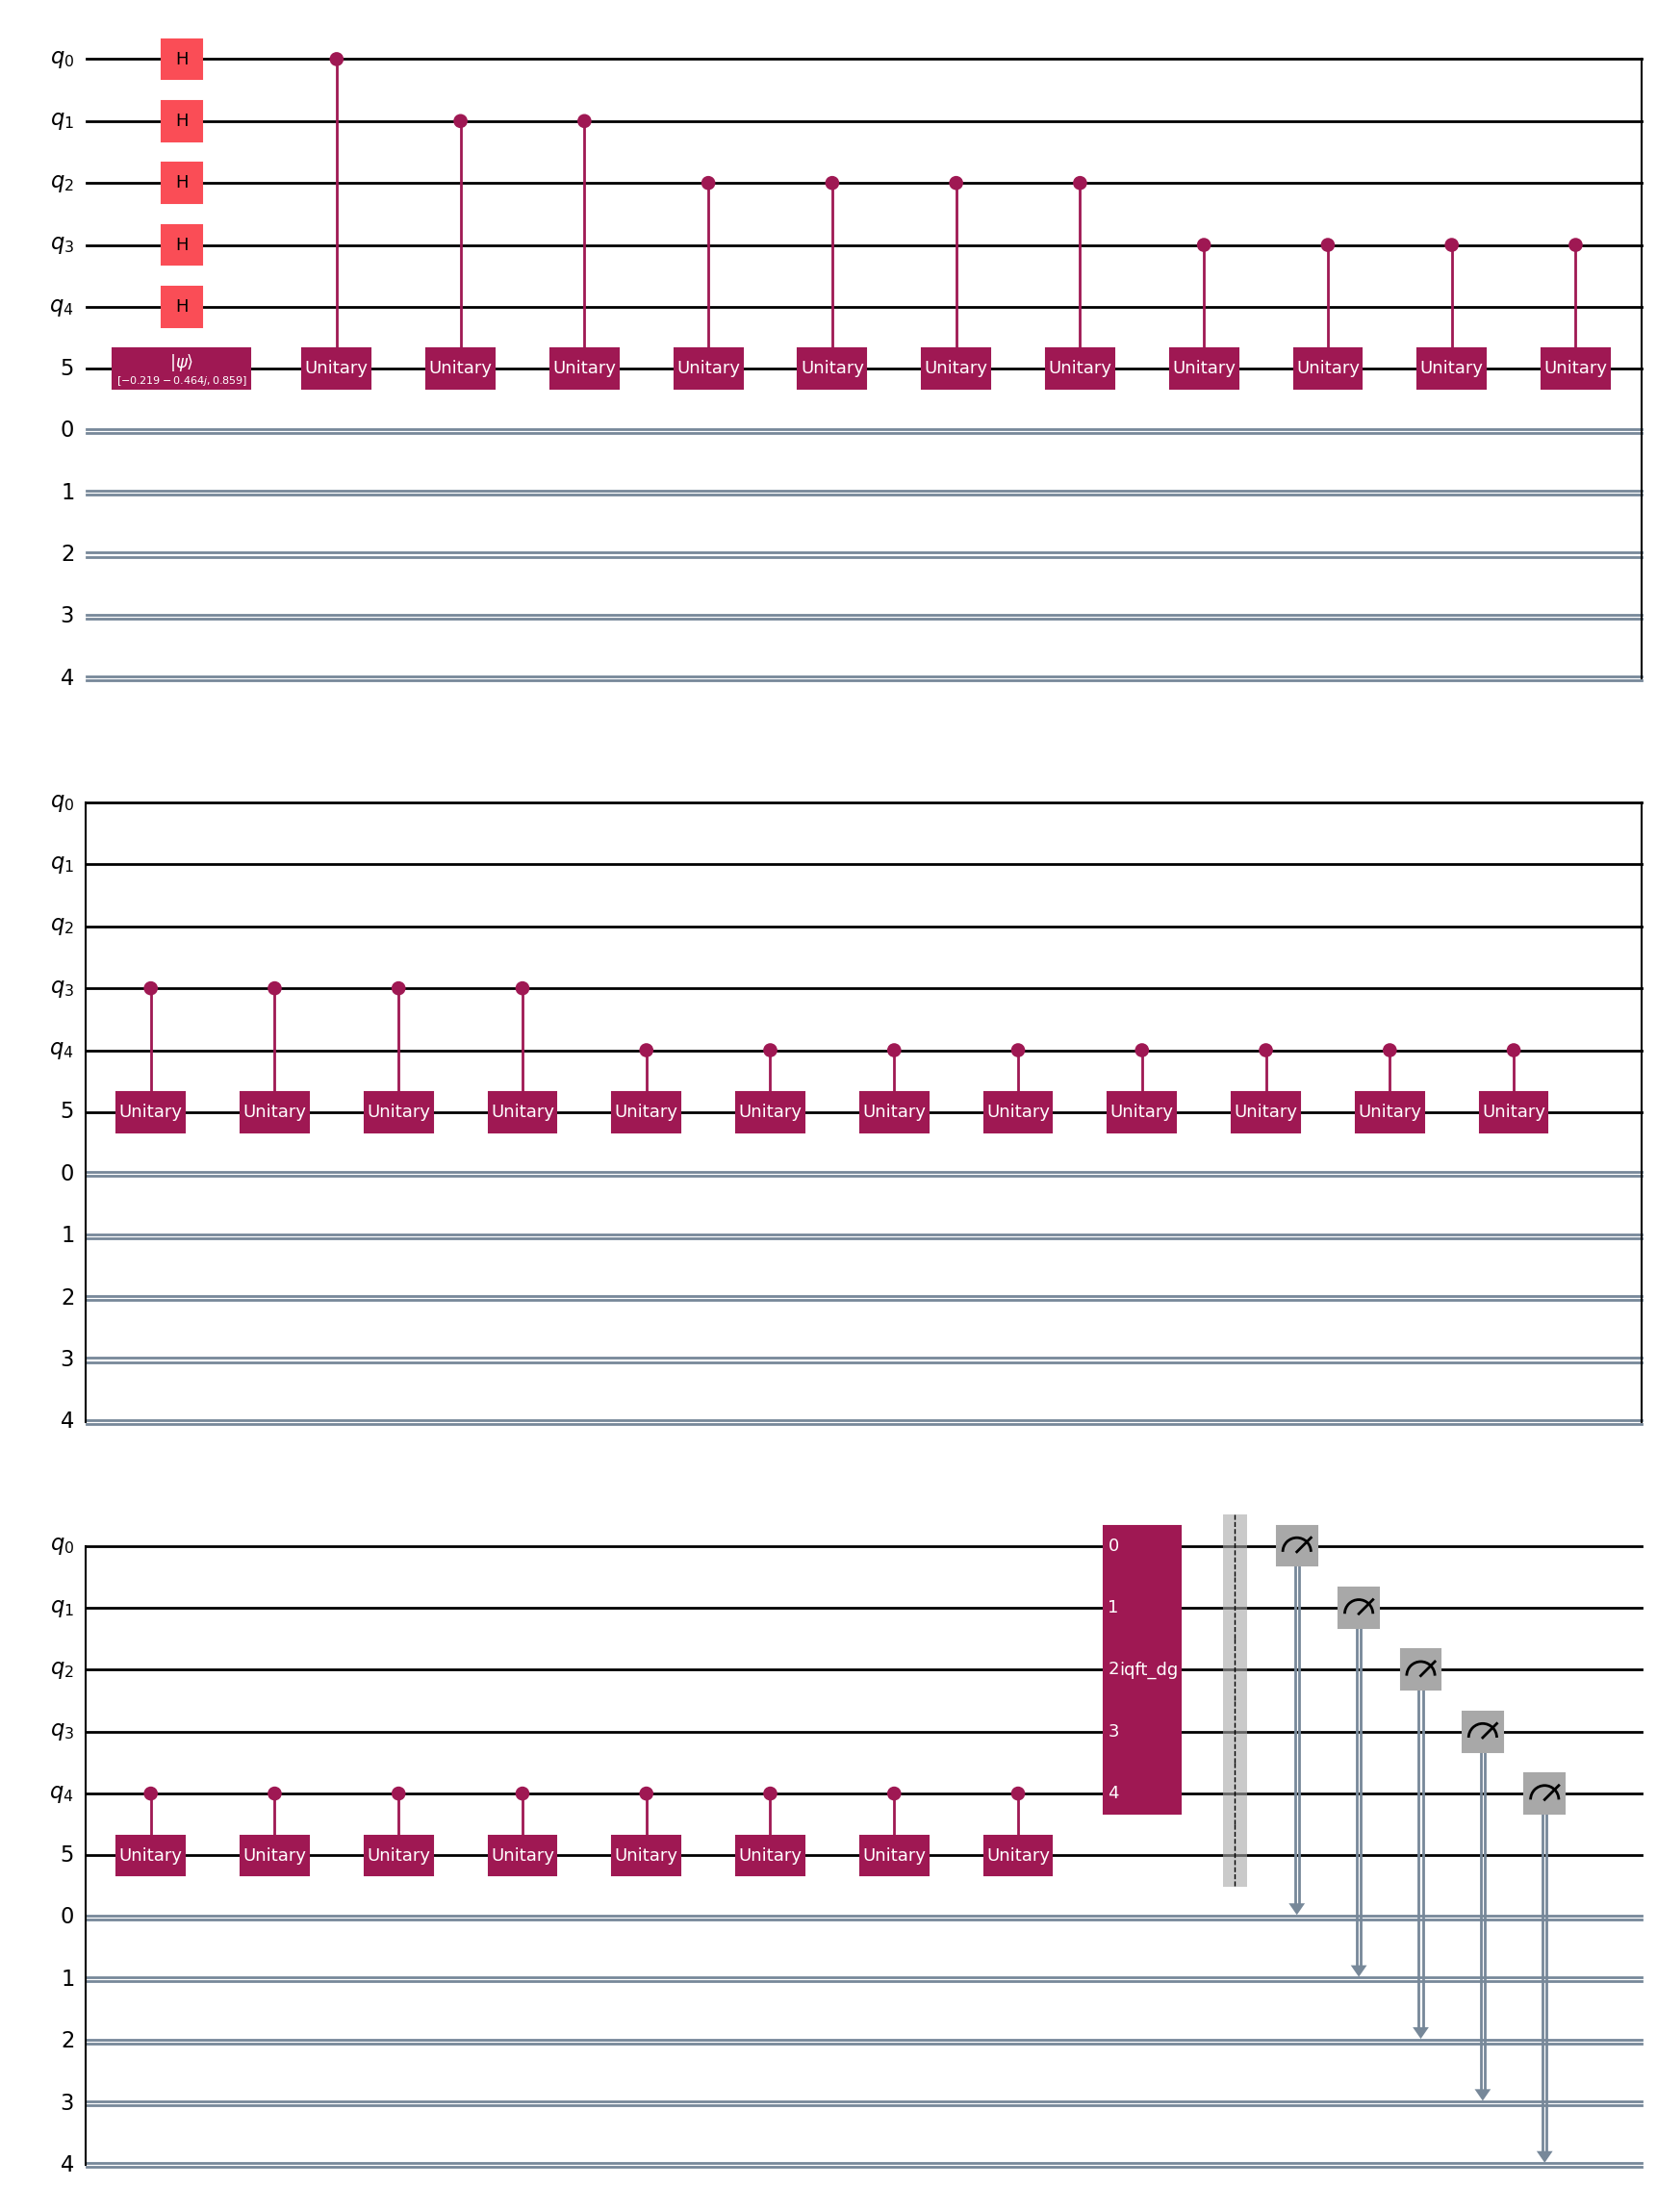

In [6]:
meas=ClassicalRegister(qc2.num_qubits-1)   
qc2.add_bits(meas)
qc2.measure(qc2.qubits[:-1],meas)
qc2.draw('mpl')


In [7]:
from qiskit.visualization import plot_histogram
backend = StatevectorSimulator()
shots=1000
job = backend.run(transpile(qc2,backend),memory=True,shots=shots)
result =  job.result()
print(result.get_counts())

{'01011': 139, '01010': 25, '01001': 13, '00001': 114, '01100': 612, '01110': 12, '00000': 16, '01101': 35, '10010': 2, '10000': 3, '01000': 3, '01111': 6, '00111': 3, '10101': 1, '10011': 1, '11111': 2, '10001': 1, '11011': 1, '00110': 1, '00100': 3, '10100': 2, '10111': 2, '00010': 1, '00101': 2}


In [8]:
found_phase = int(max(result.get_counts().keys(), key=lambda x: result.get_counts()[x]),2)/float(2**n)
print(f"found phase: {found_phase}")
print(f"expected eigen value: {eig_val}")
print(f"real eigen value: {np.exp(2*np.pi*1j*found_phase)}")

found phase: 0.375
expected eigen value: (-0.661910207401653+0.749583135707775j)
real eigen value: (-0.7071067811865475+0.7071067811865476j)


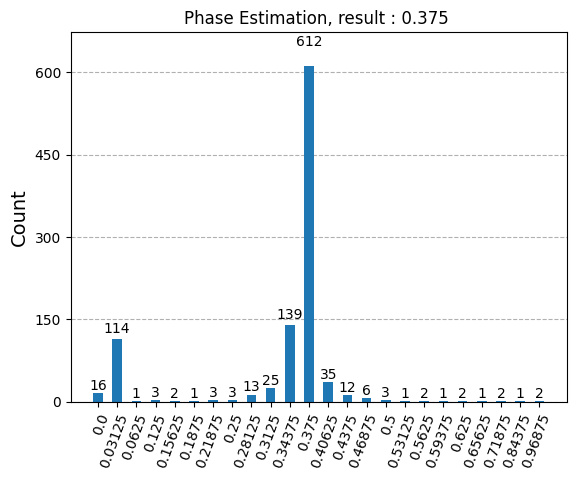

In [9]:
plot_histogram({f"{(int(key,2))/float(2**n)}": result.get_counts()[key] for key in result.get_counts().keys()},
                     title="Phase Estimation, result :" + f" {found_phase} ")
